<a href="https://colab.research.google.com/github/chinge55/nepali-currency-recognition/blob/master/Currency_Recognition_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chinge55/nepali-currency-recognition

Cloning into 'nepali-currency-recognition'...
remote: Enumerating objects: 130, done.
remote: Total 130 (delta 0), reused 0 (delta 0), pack-reused 130
Receiving objects: 100% (130/130), 158.98 MiB | 38.19 MiB/s, done.


In [2]:
import os
base_dir = 'nepali-currency-recognition/data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_ten_dir = os.path.join(train_dir, 'ten')
train_fifty_dir = os.path.join(train_dir, 'fifty')
train_hundred_dir = os.path.join(train_dir, 'hundred')
test_ten_dir = os.path.join(test_dir, 'ten')
test_fifty_dir = os.path.join(test_dir, 'fifty')
test_hundred_dir = os.path.join(test_dir, 'hundred')


In [3]:
!mv nepali-currency-recognition/data/test/hundred/hundred.jpg nepali-currency-recognition/data/train/hundred/hundred.jpg

In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [5]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical')
test_generator = train_datagen.flow_from_directory(test_dir, target_size = (150, 150), batch_size = 10, class_mode = 'categorical')

Found 100 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


In [6]:
IMG_SIZE = 150

In [7]:
num_classes = train_generator.num_classes
print(num_classes)

3


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [9]:
image, label = next(iter(train_generator))

Seems like the images need to be rescaled before plotting.

I am using a tensorflow layer to do the rescaling but it could be done in any ways. (Just divide every pixel by 255)

As I can see, there is a lack of data in this dataset. So, the best option is to create more datasets using data augmentation. 

I am using tensorflow layer for this task for this too.

Okay, that looks pretty neat but that is still not enough

In [10]:
class RandomPreprocess(layers.Layer):
  def __init__(self, factor = 0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
    self.rescale = layers.experimental.preprocessing.Rescaling(1./255)
  def random_rotate_img(self, x):
    if  tf.random.uniform([]) < self.factor:
      x = tf.image.rot90(x)
    else:
      x
    return x
  def random_flip_img(self, x):
    x = tf.image.random_flip_left_right(x)
    return x
  def random_crop_pad(self, x):
    x = tf.image.resize_with_crop_or_pad(x, IMG_SIZE + 6, IMG_SIZE + 6) 
    x = tf.image.random_crop(x, size = [IMG_SIZE, IMG_SIZE, 3] )
    return x
  def call(self, X):
    output_list = []
    for i in range(X.shape[0]):
      x = X[i]
      x = self.random_rotate_img(x) 
      x = self.random_flip_img(x)
      x = self.random_crop_pad(x)
      x = self.rescale(x)
      output_list.append(x)
    return tf.stack(output_list)

In [11]:
random_images = RandomPreprocess()(image)
random_images.shape

TensorShape([10, 150, 150, 3])

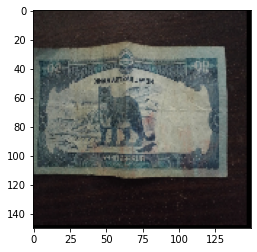

In [12]:
_ = plt.imshow(random_images[0])

In [13]:
#_ = plt.imshow((RandomPreprocess()(image)[0]))

In [14]:
# import tensorflow as tf
# class CustomModel(tf.keras.Model):
#   def __init__(self, units = 32):
#     super(CustomModel, self).__init__()
#     self.units = units
#     self.preprocessor = RandomPreprocess()
#     self.conv1 = layers.Conv2D(32, (3,3), activation = 'relu')
#     self.maxpool = layers.MaxPooling2D((2,2))
#     self.flatten = layers.Flatten()
#     self.dense = layers.Dense(units, activation = 'relu')
#     self.end_layer = layers.Dense(3, activation = 'softmax')
#   def call(self, x):
#     x = self.preprocessor(x)
#     x = self.conv1(x)
#     x = self.maxpool(x)
#     x = self.flatten(x)
#     x = self.dense(x)
#     x = self.end_layer(x)
#     return x

In [15]:
from keras import layers
from keras import models
model = models.Sequential()

In [16]:
model.add(RandomPreprocess())
model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(3, activation = 'softmax'))

In [17]:
from keras import optimizers
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics = ['acc'])
INPUT_SHAPE = (10,150, 150, 3)
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_preprocess_1 (RandomP (10, 150, 150, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (10, 148, 148, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (10, 74, 74, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (10, 72, 72, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (10, 36, 36, 64)          0         
_________________________________________________________________
flatten (Flatten)            (10, 82944)               0         
_________________________________________________________________
dense (Dense)                (10, 100)                 8

In [18]:
history = model.fit(train_generator,epochs = 100)


Epoch 1/100
10/10 [==============================] - 9s 887ms/step - loss: 1.1727 - acc: 0.4100
Epoch 2/100
10/10 [==============================] - 10s 957ms/step - loss: 1.0371 - acc: 0.5100
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 1.0003 - acc: 0.4900
Epoch 4/100
10/10 [==============================] - 10s 971ms/step - loss: 0.9716 - acc: 0.5700
Epoch 5/100
10/10 [==============================] - 10s 963ms/step - loss: 0.9800 - acc: 0.5000
Epoch 6/100
10/10 [==============================] - 10s 1000ms/step - loss: 0.9325 - acc: 0.5400
Epoch 7/100
10/10 [==============================] - 10s 968ms/step - loss: 0.8978 - acc: 0.5700
Epoch 8/100
10/10 [==============================] - 10s 977ms/step - loss: 0.8429 - acc: 0.6000
Epoch 9/100
10/10 [==============================] - 10s 1s/step - loss: 0.8525 - acc: 0.5900
Epoch 10/100
10/10 [==============================] - 11s 1s/step - loss: 0.7927 - acc: 0.6400
Epoch 11/100
10/10 [==================

KeyboardInterrupt: ignored

1. Implement Callbacks and EarlyStopping
2. Create a Custom Data generator
3. Change the model 